In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import time

In [2]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [3]:
from keras.applications.vgg19 import (
    VGG19, preprocess_input, decode_predictions)

from keras.preprocessing import image


from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import to_categorical, np_utils
from keras.models import load_model

Using TensorFlow backend.


In [4]:
def preprocess_image(img_path, target_size=(224,244), debug=False):
    """
    img_path - file path to specific image
    target_size - tuple of pixel image size
    """
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    if debug: print (x.shape)
    x = np.expand_dims(x, axis=0)
    if debug: print (x.shape)
    x = preprocess_input(x)
    if debug: print('Input image shape:', x.shape)
    return x

In [5]:
def get_images(image_dir, label, target_size=(224,224)):
    images = os.listdir(image_dir)
    preprocessed_images = []
    labels = []
    for image in images:
        image_path = os.path.join(image_dir, image)
        x = preprocess_image(image_path, target_size=target_size)
        x = np.squeeze(x, axis=0)
        preprocessed_images.append(x)
        labels.append(label)
    return (preprocessed_images, labels)

In [6]:
X_train = []
y_train = []

PATH = os.getcwd()
data_path = os.path.join(PATH,'chest_xray', 'train')
categories = ['NORMAL','PNEUMONIA']
categories_map = {category: i for i,category in enumerate(categories)}

for category in categories:
    image_dir = os.path.join(data_path, category)
    (preprocessed_images, labels) = get_images(image_dir, label=categories_map.get(category))
    X_train.extend(preprocessed_images)
    y_train.extend(labels)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [7]:
X_test = []
y_test = []

PATH = os.getcwd()
data_path = os.path.join(PATH,'chest_xray', 'test')
categories = ['NORMAL','PNEUMONIA']
categories_map = {category: i for i,category in enumerate(categories)}

for category in categories:
    image_dir = os.path.join(data_path, category)
    (preprocessed_images, labels) = get_images(image_dir, label=categories_map.get(category))
    X_test.extend(preprocessed_images)
    y_test.extend(labels)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [8]:
categories_map

{'NORMAL': 0, 'PNEUMONIA': 1}

In [9]:
from collections import Counter
Counter(y_train)

Counter({0: 1341, 1: 3875})

In [10]:
# Define the number of classes
num_classes = len(categories)
# convert class labels to on-hot encoding
y_train = np_utils.to_categorical(y_train, num_classes)


In [11]:
y_train.shape

(5216, 2)

In [12]:
y_test=np_utils.to_categorical(y_test, num_classes)

In [13]:
y_test.shape

(624, 2)

In [14]:
input = Input(shape=(224, 224, 3))
base_model = VGG19(include_top=False, weights='imagenet', input_tensor=input, input_shape=(224, 224, 3), pooling='avg', classes=1000)
for l in base_model.layers:
    l.trainable = False

t = base_model(input)
o = Dense(2, activation='softmax')(t)
model = Model(inputs=input, outputs=o)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
history = model.fit(X_train, y_train, batch_size=32, validation_data = (X_test , y_test), epochs=4, verbose=1)

Train on 5216 samples, validate on 624 samples
Epoch 1/4
5216/5216 [==============================] - 2496s 479ms/step - loss: 0.3018 - acc: 0.8930 - val_loss: 0.5545 - val_acc: 0.8189
Epoch 2/4
5216/5216 [==============================] - 2545s 488ms/step - loss: 0.1172 - acc: 0.9609 - val_loss: 0.6159 - val_acc: 0.8173
Epoch 3/4
5216/5216 [==============================] - 2555s 490ms/step - loss: 0.0877 - acc: 0.9674 - val_loss: 0.5026 - val_acc: 0.8446
Epoch 4/4
5216/5216 [==============================] - 2527s 484ms/step - loss: 0.0671 - acc: 0.9758 - val_loss: 0.6265 - val_acc: 0.8109


In [16]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 512)               20024384  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 20,025,410
Trainable params: 1,026
Non-trainable params: 20,024,384
_________________________________________________________________
None


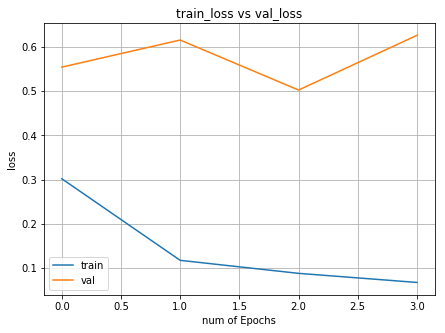

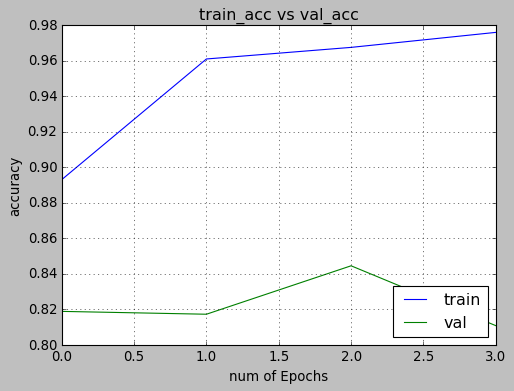

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['acc']
val_acc=history.history['val_acc']
xc=range(len(train_loss))


plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [18]:
model.save("custom_vgg.h5")

In [19]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

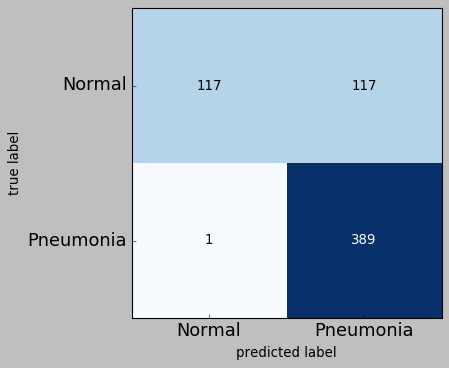

In [20]:
target_names = ['Normal', 'pneumonia']
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [ ]:
# print(y_true, pred)

In [21]:
# Calculate Precision and Recall
tn, fp, fn, tp = CM.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 1.00
Precision of the model is 0.77


In [22]:
386 / (386+128)

0.7509727626459144

In [23]:
386 / (386+4)

0.9897435897435898